In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

Path('figures').mkdir(exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Benchmark names
benchmarks = ['HellaSwag', 'ARC-Easy', 'ARC-Challenge', 'WinoGrande', 'MMLU']

# Results data
results = {
    'Teacher (FP32)': [0.5262, 0.8308, 0.5572, 0.6835, 0.7067],
    'Off-policy (λ=0)': [0.5149, 0.8165, 0.5375, 0.6875, 0.6822],
    'On-policy (λ=1)': [0.5121, 0.8186, 0.5333, 0.6764, 0.6855],
    'Mixed (λ=0.5)': [0.5160, 0.8194, 0.5333, 0.6803, 0.6857],
}

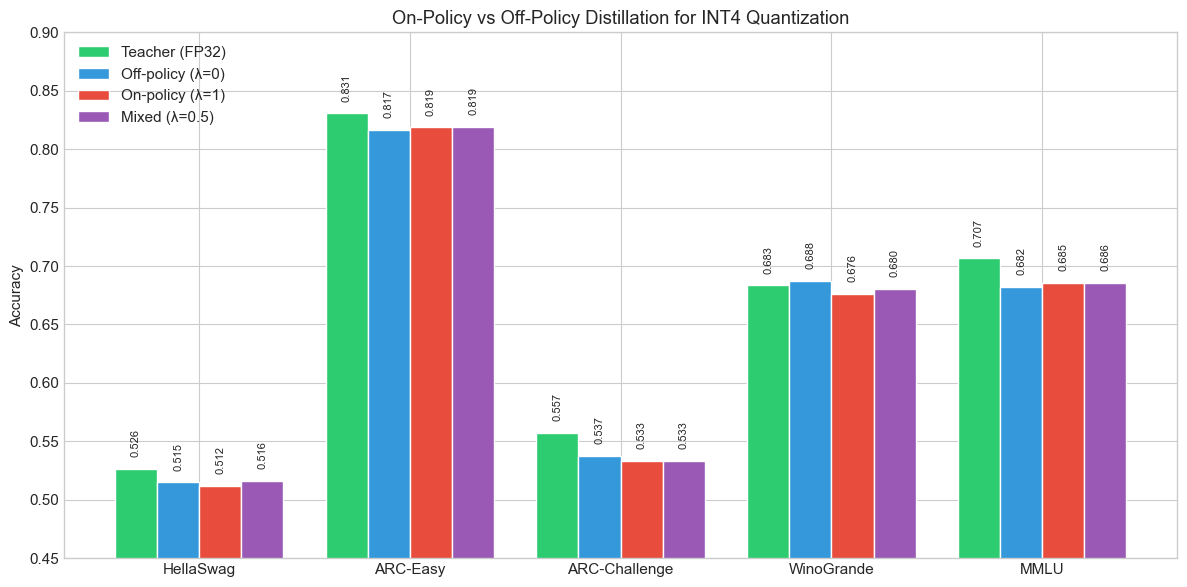

In [2]:
# Figure 1: Main comparison - On-policy vs Off-policy vs Teacher
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(benchmarks))
width = 0.2
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

for i, (model, scores) in enumerate(results.items()):
    bars = ax.bar(x + i * width, scores, width, label=model, color=colors[i], edgecolor='white')

ax.set_ylabel('Accuracy')
ax.set_title('On-Policy vs Off-Policy Distillation for INT4 Quantization')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(benchmarks)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax.set_ylim(0.45, 0.9)

# Add value labels on bars
for i, (model, scores) in enumerate(results.items()):
    for j, score in enumerate(scores):
        ax.text(j + i * width, score + 0.01, f'{score:.3f}', ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout()
plt.savefig('figures/main_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

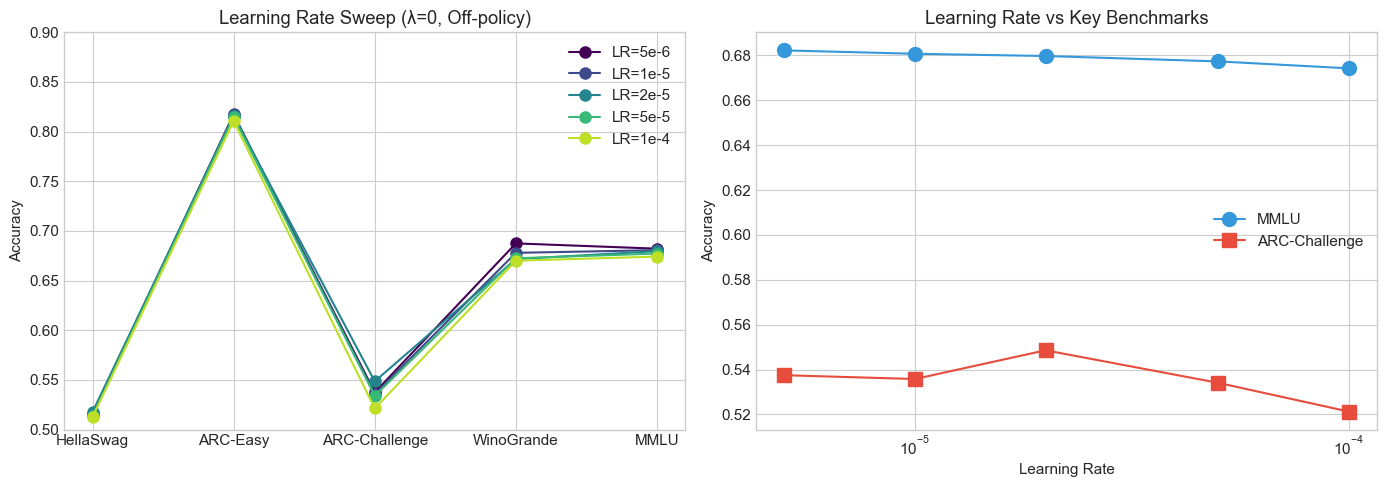

In [3]:
# Figure 2: Learning Rate Sweep (Off-policy λ=0)
lr_data = {
    '5e-6': [0.5149, 0.8165, 0.5375, 0.6875, 0.6822],
    '1e-5': [0.5153, 0.8178, 0.5358, 0.6780, 0.6807],
    '2e-5': [0.5177, 0.8157, 0.5486, 0.6717, 0.6797],
    '5e-5': [0.5137, 0.8148, 0.5341, 0.6725, 0.6773],
    '1e-4': [0.5127, 0.8106, 0.5213, 0.6701, 0.6742],
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Line plot across benchmarks
lrs = list(lr_data.keys())
colors_lr = plt.cm.viridis(np.linspace(0, 0.9, len(lrs)))

for i, (lr, scores) in enumerate(lr_data.items()):
    axes[0].plot(benchmarks, scores, 'o-', label=f'LR={lr}', color=colors_lr[i], markersize=8)

axes[0].set_ylabel('Accuracy')
axes[0].set_title('Learning Rate Sweep (λ=0, Off-policy)')
axes[0].legend()
axes[0].set_ylim(0.5, 0.9)

# Right: Focus on MMLU and ARC-Challenge (most discriminative)
lr_values = [5e-6, 1e-5, 2e-5, 5e-5, 1e-4]
mmlu_scores = [0.6822, 0.6807, 0.6797, 0.6773, 0.6742]
arc_scores = [0.5375, 0.5358, 0.5486, 0.5341, 0.5213]

ax2 = axes[1]
ax2.plot(lr_values, mmlu_scores, 'o-', label='MMLU', color='#3498db', markersize=10)
ax2.plot(lr_values, arc_scores, 's-', label='ARC-Challenge', color='#e74c3c', markersize=10)
ax2.set_xscale('log')
ax2.set_xlabel('Learning Rate')
ax2.set_ylabel('Accuracy')
ax2.set_title('Learning Rate vs Key Benchmarks')
ax2.legend()

plt.tight_layout()
plt.savefig('figures/lr_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

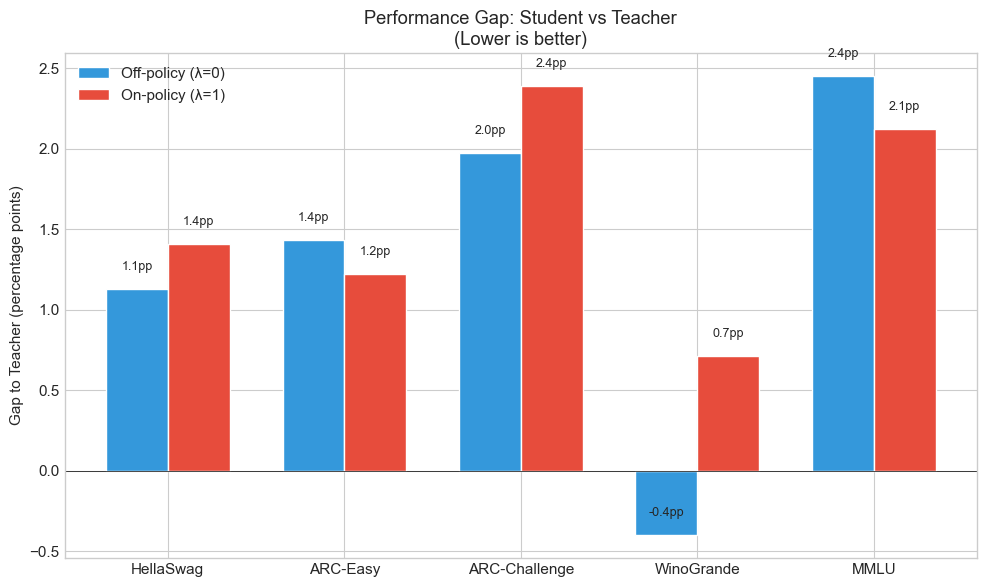


Key Insight: The gap to teacher is similar for both approaches (~2-3pp),
with differences between λ=0 and λ=1 being < 0.5pp (within noise).


In [4]:
# Figure 3: Gap to Teacher - The key takeaway
teacher = np.array([0.5262, 0.8308, 0.5572, 0.6835, 0.7067])
off_policy = np.array([0.5149, 0.8165, 0.5375, 0.6875, 0.6822])
on_policy = np.array([0.5121, 0.8186, 0.5333, 0.6764, 0.6855])

gap_off = (teacher - off_policy) * 100  # percentage points
gap_on = (teacher - on_policy) * 100

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(benchmarks))
width = 0.35

bars1 = ax.bar(x - width/2, gap_off, width, label='Off-policy (λ=0)', color='#3498db', edgecolor='white')
bars2 = ax.bar(x + width/2, gap_on, width, label='On-policy (λ=1)', color='#e74c3c', edgecolor='white')

ax.set_ylabel('Gap to Teacher (percentage points)')
ax.set_title('Performance Gap: Student vs Teacher\n(Lower is better)')
ax.set_xticks(x)
ax.set_xticklabels(benchmarks)
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1, f'{height:.1f}pp', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1, f'{height:.1f}pp', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('figures/gap_to_teacher.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nKey Insight: The gap to teacher is similar for both approaches (~2-3pp),")
print("with differences between λ=0 and λ=1 being < 0.5pp (within noise).")

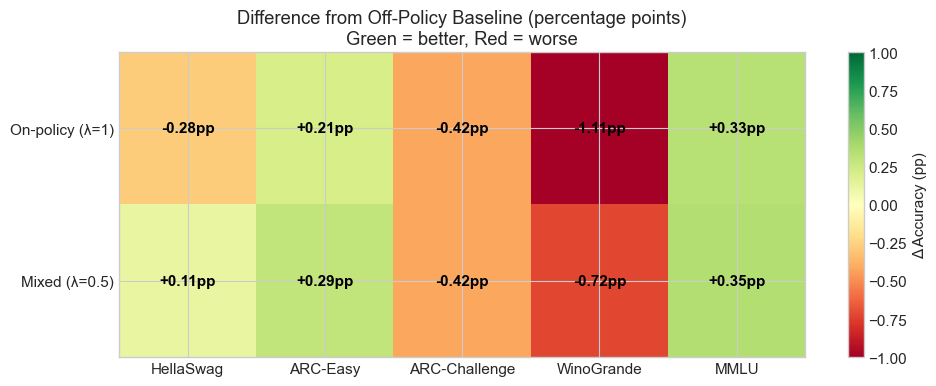


Conclusion: Differences are < 0.5pp across all benchmarks.
On-policy and off-policy perform equivalently for INT4 quantization.


In [5]:
# Figure 4: Summary heatmap - difference from off-policy baseline
models = ['Off-policy (λ=0)', 'On-policy (λ=1)', 'Mixed (λ=0.5)']
data = np.array([
    [0.5149, 0.8165, 0.5375, 0.6875, 0.6822],  # Off-policy (baseline)
    [0.5121, 0.8186, 0.5333, 0.6764, 0.6855],  # On-policy
    [0.5160, 0.8194, 0.5333, 0.6803, 0.6857],  # Mixed
])

# Calculate difference from off-policy (λ=0) baseline
diff = (data - data[0]) * 100  # percentage points

fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(diff[1:], cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(benchmarks)))
ax.set_yticks(np.arange(len(models) - 1))
ax.set_xticklabels(benchmarks)
ax.set_yticklabels(models[1:])

# Add text annotations
for i in range(len(models) - 1):
    for j in range(len(benchmarks)):
        val = diff[i + 1, j]
        text = ax.text(j, i, f'{val:+.2f}pp', ha='center', va='center',
                       color='black', fontsize=11, fontweight='bold')

ax.set_title('Difference from Off-Policy Baseline (percentage points)\nGreen = better, Red = worse')
fig.colorbar(im, ax=ax, label='Δ Accuracy (pp)')

plt.tight_layout()
plt.savefig('figures/heatmap_diff.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConclusion: Differences are < 0.5pp across all benchmarks.")
print("On-policy and off-policy perform equivalently for INT4 quantization.")

In [6]:
# Load training loss data
import pandas as pd

df = pd.read_csv('train-loss.csv')

# Extract just the main loss columns (not MIN/MAX)
loss_cols = [c for c in df.columns if 'train/loss' in c and 'MIN' not in c and 'MAX' not in c]
print(f"Available runs: {[c.replace(' - train/loss', '') for c in loss_cols]}")
df.head()

Available runs: ['lmbda0_lr5e5_steps20k', 'lmbda1_lr1e4', 'lmbda1_lr5e5', 'lmbda0_beta1', 'lmbda0_lr1e4', 'lmbda1_tok512', 'lmbda1_bs16', 'lmbda1_tok256', 'lmbda1_beta05', 'lmbda0_beta05']


,Step,lmbda0_lr5e5_steps20k - train/loss,lmbda0_lr5e5_steps20k - train/loss__MIN,lmbda0_lr5e5_steps20k - train/loss__MAX,lmbda1_lr1e4 - train/loss,lmbda1_lr1e4 - train/loss__MIN,lmbda1_lr1e4 - train/loss__MAX,lmbda1_lr5e5 - train/loss,lmbda1_lr5e5 - train/loss__MIN,lmbda1_lr5e5 - train/loss__MAX,...,lmbda1_bs16 - train/loss__MAX,lmbda1_tok256 - train/loss,lmbda1_tok256 - train/loss__MIN,lmbda1_tok256 - train/loss__MAX,lmbda1_beta05 - train/loss,lmbda1_beta05 - train/loss__MIN,lmbda1_beta05 - train/loss__MAX,lmbda0_beta05 - train/loss,lmbda0_beta05 - train/loss__MIN,lmbda0_beta05 - train/loss__MAX
0,0,0.3661,0.3661,0.3661,0.4697,0.4697,0.4697,0.4697,0.4697,0.4697,...,0.8721,0.9203,0.9203,0.9203,0.1467,0.1467,0.1467,0.1198,0.1198,0.1198
1,1,NaN,NaN,NaN,0.4260,0.4260,0.4260,0.4260,0.4260,0.4260,...,0.9281,0.8376,0.8376,0.8376,0.1338,0.1338,0.1338,0.1181,0.1181,0.1181
2,2,NaN,NaN,NaN,0.4776,0.4776,0.4776,0.4894,0.4894,0.4894,...,0.8247,0.9444,0.9444,0.9444,0.1593,0.1593,0.1593,0.1279,0.1279,0.1279
3,3,0.3441,0.3441,0.3441,0.4820,0.4820,0.4820,0.4814,0.4814,0.4814,...,0.8597,0.9049,0.9049,0.9049,0.1392,0.1392,0.1392,0.1056,0.1056,0.1056
4,4,0.3301,0.3301,0.3301,0.4025,0.4025,0.4025,0.4027,0.4027,0.4027,...,0.8993,0.7878,0.7878,0.7878,0.1294,0.1294,0.1294,0.1069,0.1069,0.1069


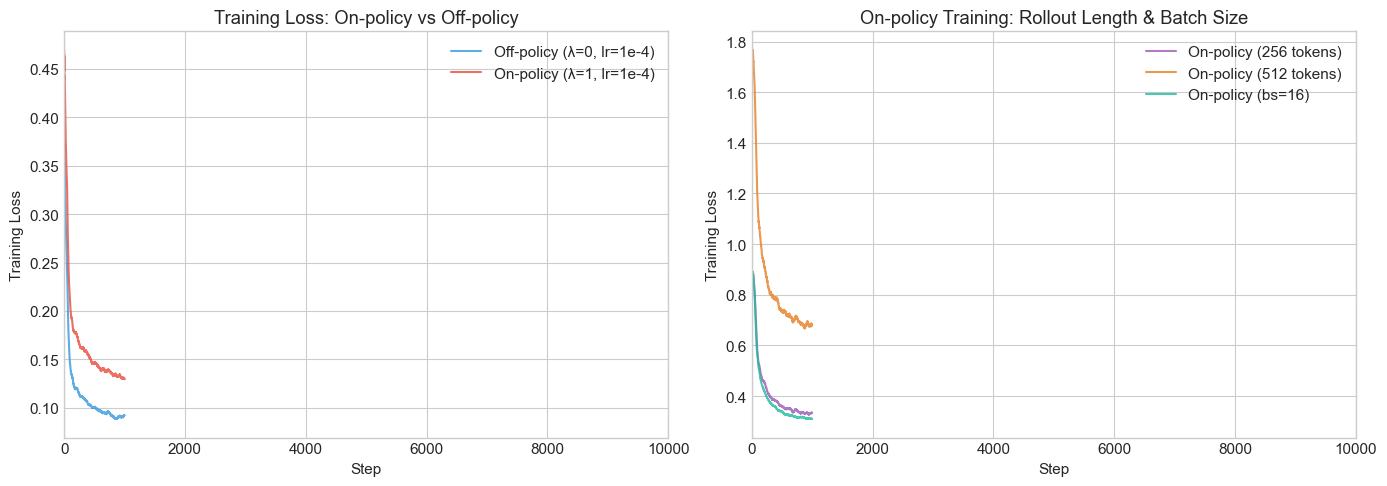

In [ ]:
# Figure 5: Training loss curves - On-policy vs Off-policy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Helper to get smoothed loss
def smooth(y, window=50):
    return pd.Series(y).rolling(window, min_periods=1).mean()

# Left: Compare λ=0 vs λ=1 runs
ax = axes[0]
runs_to_plot = {
    'lmbda0_lr1e4': ('Off-policy (λ=0, lr=1e-4)', '#3498db'),
    'lmbda1_lr1e4': ('On-policy (λ=1, lr=1e-4)', '#e74c3c'),
}

for run_key, (label, color) in runs_to_plot.items():
    col = f'{run_key} - train/loss'
    if col in df.columns:
        data = df[['Step', col]].dropna()
        ax.plot(data['Step'], smooth(data[col]), label=label, color=color, alpha=0.8)

ax.set_xlabel('Step')
ax.set_ylabel('Training Loss')
ax.set_title('Training Loss: On-policy vs Off-policy')
ax.legend()
ax.set_xlim(0, 10000)

# Right: Different rollout lengths for on-policy
ax = axes[1]
rollout_runs = {
    'lmbda1_tok256': ('On-policy (256 tokens)', '#9b59b6'),
    'lmbda1_tok512': ('On-policy (512 tokens)', '#e67e22'),
    'lmbda1_bs16': ('On-policy (bs=16)', '#1abc9c'),
}

for run_key, (label, color) in rollout_runs.items():
    col = f'{run_key} - train/loss'
    if col in df.columns:
        data = df[['Step', col]].dropna()
        ax.plot(data['Step'], smooth(data[col]), label=label, color=color, alpha=0.8)

ax.set_xlabel('Step')
ax.set_ylabel('Training Loss')
ax.set_title('On-policy Training: Rollout Length & Batch Size')
ax.legend()
ax.set_xlim(0, 10000)

plt.tight_layout()
plt.savefig('figures/training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

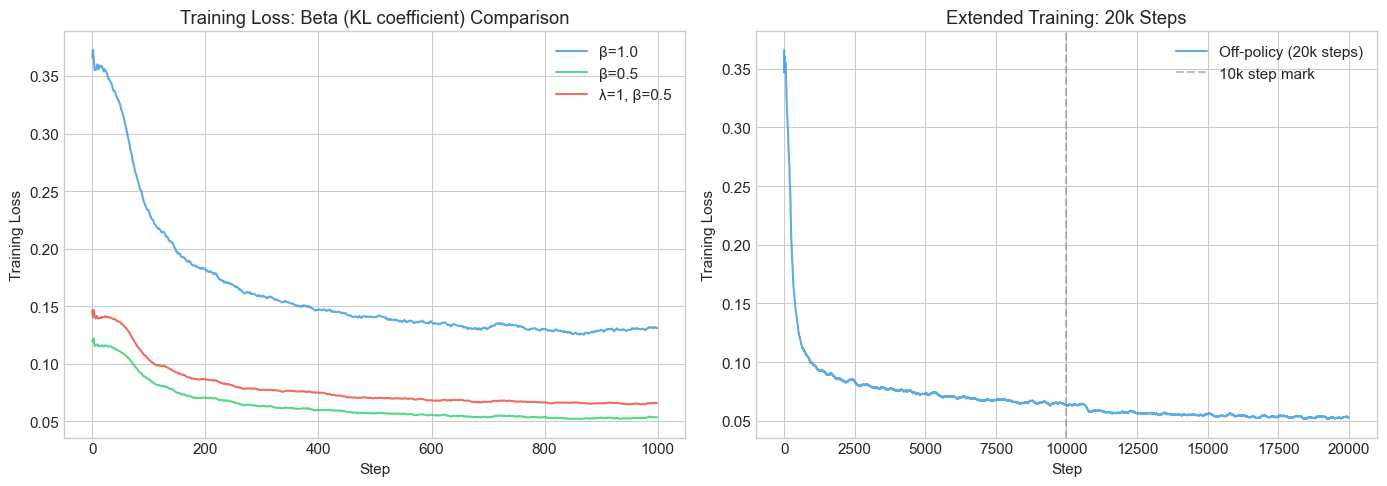


Note: On-policy runs (λ=1) have higher loss values because they train on
student-generated sequences which are harder to fit than dataset sequences.


In [9]:
# Figure 6: Beta sweep and longer training
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Beta sweep (KL coefficient)
ax = axes[0]
beta_runs = {
    'lmbda0_beta1': ('β=1.0', '#3498db'),
    'lmbda0_beta05': ('β=0.5', '#2ecc71'),
    'lmbda1_beta05': ('λ=1, β=0.5', '#e74c3c'),
}

for run_key, (label, color) in beta_runs.items():
    col = f'{run_key} - train/loss'
    if col in df.columns:
        data = df[['Step', col]].dropna()
        ax.plot(data['Step'], smooth(data[col]), label=label, color=color, alpha=0.8)

ax.set_xlabel('Step')
ax.set_ylabel('Training Loss')
ax.set_title('Training Loss: Beta (KL coefficient) Comparison')
ax.legend()
# ax.set_xlim(0, 10000)

# Right: Longer training (20k steps)
ax = axes[1]
col = 'lmbda0_lr5e5_steps20k - train/loss'
if col in df.columns:
    data = df[['Step', col]].dropna()
    ax.plot(data['Step'], smooth(data[col], window=100), label='Off-policy (20k steps)', color='#3498db', alpha=0.8)
    ax.axvline(x=10000, color='gray', linestyle='--', alpha=0.5, label='10k step mark')

ax.set_xlabel('Step')
ax.set_ylabel('Training Loss')
ax.set_title('Extended Training: 20k Steps')
ax.legend()

plt.tight_layout()
plt.savefig('figures/training_loss_extended.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nNote: On-policy runs (λ=1) have higher loss values because they train on")
print("student-generated sequences which are harder to fit than dataset sequences.")